# Masked Self Attention

## Zero Masking After Softmax

### Self Attention Class

In [2]:
import torch
import torch.nn as nn

In [3]:
class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out):
        super(SelfAttention_v2, self).__init__()
        self.Wq = nn.Linear(d_in, d_out, bias=False)
        self.Wk = nn.Linear(d_in, d_out, bias=False)
        self.Wv = nn.Linear(d_in, d_out, bias=False)

    def forward(self, input_embeddings):
        queries = self.Wq(input_embeddings)
        keys = self.Wk(input_embeddings)
        values = self.Wv(input_embeddings)

        dk = keys.shape[-1] # d_out
        attention_scores = queries @ keys.T
        attention_weights = torch.softmax(attention_scores / (dk ** 0.5), dim=-1)
        context_vectors = attention_weights @ values

        return context_vectors

### Input Embeddings

In [4]:
D_IN = 4
D_OUT = 3
NUM_TOKENS = 6
CONTEXT_SIZE = 6

In [5]:
torch.manual_seed(0)
input_embeddings = torch.randn(NUM_TOKENS, D_IN)

print(f"Input Embeddings:\n{input_embeddings}\nShape: {input_embeddings.shape}\n")

Input Embeddings:
tensor([[-1.1258, -1.1524, -0.2506, -0.4339],
        [ 0.8487,  0.6920, -0.3160, -2.1152],
        [ 0.4681, -0.1577,  1.4437,  0.2660],
        [ 0.1665,  0.8744, -0.1435, -0.1116],
        [ 0.9318,  1.2590,  2.0050,  0.0537],
        [ 0.6181, -0.4128, -0.8411, -2.3160]])
Shape: torch.Size([6, 4])



### Attention Weights after Softmax

In [7]:
self_attention = SelfAttention_v2(D_IN, D_OUT)

queries = self_attention.Wq(input_embeddings)
keys = self_attention.Wk(input_embeddings)

attention_scores = queries @ keys.T
dk = keys.shape[-1] # d_out

attention_weights = torch.softmax(attention_scores / (dk ** 0.5), dim=-1)

print(f"Attention Weights:\n{attention_weights}\nShape: {attention_weights.shape}\n")

Attention Weights:
tensor([[0.1599, 0.1638, 0.1769, 0.1606, 0.1667, 0.1720],
        [0.0997, 0.2747, 0.0869, 0.1480, 0.0934, 0.2972],
        [0.1647, 0.1650, 0.1699, 0.1660, 0.1687, 0.1656],
        [0.1443, 0.2144, 0.1244, 0.1705, 0.1366, 0.2099],
        [0.1164, 0.2608, 0.0932, 0.1651, 0.1094, 0.2551],
        [0.1293, 0.2126, 0.1371, 0.1532, 0.1290, 0.2387]],
       grad_fn=<SoftmaxBackward0>)
Shape: torch.Size([6, 6])



### Zero Mask

In [8]:
mask = torch.tril(torch.ones(CONTEXT_SIZE, CONTEXT_SIZE))

print(f"Mask:\n{mask}\nShape: {mask.shape}\n")

Mask:
tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])
Shape: torch.Size([6, 6])



### Zero Masked Attention Weights

In [9]:
zero_masked_attention_weights = attention_weights * mask

print(f"Zero-Masked Attention Weights:\n{zero_masked_attention_weights}\nShape: {zero_masked_attention_weights.shape}\n")

Zero-Masked Attention Weights:
tensor([[0.1599, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0997, 0.2747, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1647, 0.1650, 0.1699, 0.0000, 0.0000, 0.0000],
        [0.1443, 0.2144, 0.1244, 0.1705, 0.0000, 0.0000],
        [0.1164, 0.2608, 0.0932, 0.1651, 0.1094, 0.0000],
        [0.1293, 0.2126, 0.1371, 0.1532, 0.1290, 0.2387]],
       grad_fn=<MulBackward0>)
Shape: torch.Size([6, 6])



### Normalization

In [10]:
row_sums = torch.sum(zero_masked_attention_weights, dim=-1, keepdim=True)

print(f"Row Sums:\n{row_sums}\nShape: {row_sums.shape}\n")

Row Sums:
tensor([[0.1599],
        [0.3745],
        [0.4996],
        [0.6535],
        [0.7449],
        [1.0000]], grad_fn=<SumBackward1>)
Shape: torch.Size([6, 1])



In [11]:
normalized_zero_masked_attention_weights = zero_masked_attention_weights / row_sums

print(f"Normalized Zero-Masked Attention Weights:\n{normalized_zero_masked_attention_weights}\nShape: {normalized_zero_masked_attention_weights.shape}\n")

Normalized Zero-Masked Attention Weights:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2664, 0.7336, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3297, 0.3302, 0.3401, 0.0000, 0.0000, 0.0000],
        [0.2207, 0.3280, 0.1904, 0.2609, 0.0000, 0.0000],
        [0.1563, 0.3500, 0.1252, 0.2216, 0.1469, 0.0000],
        [0.1293, 0.2126, 0.1371, 0.1532, 0.1290, 0.2387]],
       grad_fn=<DivBackward0>)
Shape: torch.Size([6, 6])



### Data Leak Issue

* The above approach leads to data leak
* The attention weights were already influenced by masked items because the denominator in the softmax computation involves all the tokens

## Negative Infinity Masking before Softmax

### Attention Scores

In [13]:
print(f"Attention Scores:\n{attention_scores}\nShape: {attention_scores.shape}\n")

Attention Scores:
tensor([[-0.0831, -0.0415,  0.0916, -0.0756, -0.0111,  0.0430],
        [-0.4079,  1.3470, -0.6458,  0.2759, -0.5226,  1.4833],
        [-0.0263, -0.0238,  0.0274, -0.0125,  0.0151, -0.0168],
        [-0.0963,  0.5897, -0.3527,  0.1928, -0.1914,  0.5535],
        [-0.2576,  1.1390, -0.6422,  0.3476, -0.3654,  1.1008],
        [-0.2812,  0.5797, -0.1801,  0.0124, -0.2864,  0.7805]],
       grad_fn=<MmBackward0>)
Shape: torch.Size([6, 6])



### Negative Infinity Masking

In [15]:
mask = torch.triu(torch.ones(CONTEXT_SIZE, CONTEXT_SIZE), diagonal=1)

print(f"Mask:\n{mask}\nShape: {mask.shape}\n")

Mask:
tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])
Shape: torch.Size([6, 6])



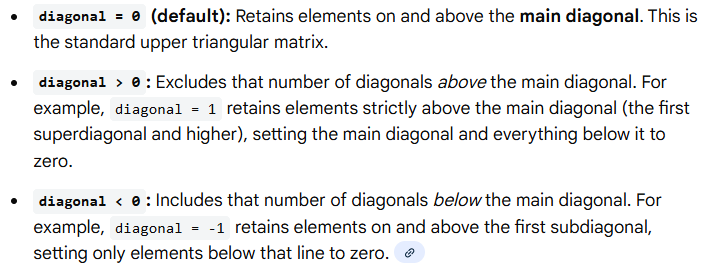

In [16]:
bool_mask = mask.bool()

print(f"Boolean Mask:\n{bool_mask}\nShape: {bool_mask.shape}\n")

Boolean Mask:
tensor([[False,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True],
        [False, False, False, False,  True,  True],
        [False, False, False, False, False,  True],
        [False, False, False, False, False, False]])
Shape: torch.Size([6, 6])



In [17]:
neg_inffinity_filled_attention_scores = attention_scores.masked_fill(bool_mask, -torch.inf)

print(f"Negative Infinity-Filled Attention Scores:\n{neg_inffinity_filled_attention_scores}\nShape: {neg_inffinity_filled_attention_scores.shape}\n")

Negative Infinity-Filled Attention Scores:
tensor([[-0.0831,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.4079,  1.3470,    -inf,    -inf,    -inf,    -inf],
        [-0.0263, -0.0238,  0.0274,    -inf,    -inf,    -inf],
        [-0.0963,  0.5897, -0.3527,  0.1928,    -inf,    -inf],
        [-0.2576,  1.1390, -0.6422,  0.3476, -0.3654,    -inf],
        [-0.2812,  0.5797, -0.1801,  0.0124, -0.2864,  0.7805]],
       grad_fn=<MaskedFillBackward0>)
Shape: torch.Size([6, 6])



### Softmax

In [18]:
neg_infinity_filled_attention_weights = torch.softmax(neg_inffinity_filled_attention_scores / (dk ** 0.5), dim=-1)

print(f"Negative Infinity-Filled Attention Weights:\n{neg_infinity_filled_attention_weights}\nShape: {neg_infinity_filled_attention_weights.shape}\n")

Negative Infinity-Filled Attention Weights:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2664, 0.7336, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3297, 0.3302, 0.3401, 0.0000, 0.0000, 0.0000],
        [0.2207, 0.3280, 0.1904, 0.2609, 0.0000, 0.0000],
        [0.1563, 0.3500, 0.1252, 0.2216, 0.1469, 0.0000],
        [0.1293, 0.2126, 0.1371, 0.1532, 0.1290, 0.2387]],
       grad_fn=<SoftmaxBackward0>)
Shape: torch.Size([6, 6])



* This method ensures no information leak occurs
* Also, this method is more efficient than previous one
* No further normalization is required as all rows already sums to 1

## Dropout

In [19]:
example = torch.ones(6,6)

print(f"Example:\n{example}")

Example:
tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])


In [20]:
dropout1 = nn.Dropout(0.5)
dropped_example1 = dropout1(example)

print(f"Dropped Example 1:\n{dropped_example1}")

Dropped Example 1:
tensor([[0., 0., 2., 0., 0., 2.],
        [2., 0., 0., 2., 2., 0.],
        [2., 0., 0., 0., 2., 0.],
        [2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 0.],
        [0., 2., 0., 2., 2., 0.]])


In [21]:
dropout2 = nn.Dropout(0.2)
dropped_example2 = dropout2(example)

print(f"Dropped Example 2:\n{dropped_example2}")

Dropped Example 2:
tensor([[0.0000, 1.2500, 1.2500, 1.2500, 1.2500, 1.2500],
        [1.2500, 1.2500, 1.2500, 0.0000, 1.2500, 1.2500],
        [1.2500, 0.0000, 1.2500, 0.0000, 0.0000, 1.2500],
        [1.2500, 1.2500, 1.2500, 1.2500, 1.2500, 1.2500],
        [1.2500, 1.2500, 1.2500, 1.2500, 1.2500, 1.2500],
        [1.2500, 0.0000, 1.2500, 0.0000, 1.2500, 1.2500]])


In [22]:
dropped_attention_weights = nn.Dropout(0.5)(neg_infinity_filled_attention_weights)

print(f"Dropped Attention Weights:\n{dropped_attention_weights}\nShape: {dropped_attention_weights.shape}\n")

Dropped Attention Weights:
tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5327, 1.4673, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6594, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4415, 0.6560, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2937, 0.0000],
        [0.0000, 0.0000, 0.2742, 0.0000, 0.0000, 0.4775]],
       grad_fn=<MulBackward0>)
Shape: torch.Size([6, 6])



## Causal Attention Class

In [27]:
class CausalSelfAttention(nn.Module):
    def __init__(self, d_in, d_out, dropout_prob, context_size):
        super(CausalSelfAttention, self).__init__()
        self.Wq = nn.Linear(d_in, d_out, bias=False)
        self.Wk = nn.Linear(d_in, d_out, bias=False)
        self.Wv = nn.Linear(d_in, d_out, bias=False)
        self.dropout = nn.Dropout(dropout_prob)
        self.register_buffer("mask", torch.triu(torch.ones(context_size, context_size), diagonal=1))

    def forward(self, input_embeddings):
        num_batch, num_tokens, d_in = input_embeddings.size()
        queries = self.Wq(input_embeddings)
        keys = self.Wk(input_embeddings)
        values = self.Wv(input_embeddings)

        dk = keys.shape[-1] # d_out
        attention_scores = queries @ keys.transpose(1, 2)

        masked_attention_scores = attention_scores.masked_fill(mask.bool()[:num_tokens, :num_tokens], -torch.inf)

        attention_weights = torch.softmax(masked_attention_scores / (dk ** 0.5), dim=-1)
        dropped_attention_weights = self.dropout(attention_weights)

        context_vectors = dropped_attention_weights @ values

        return context_vectors

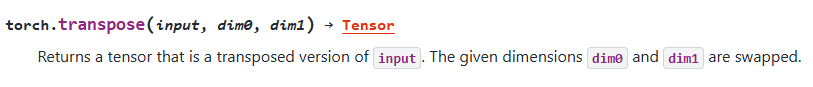

Why mask[:num_tokens, :num_tokens] inside forward()?
* mask is fixed in __init__ with context_size x context_size.
* In batch processing, the final batch might have number of tokens < context_size
* This would help in dealing those case

Why mask is put in buffer?
* While training, buffers will be moved with the model to the appropriate device (CPU/GPU) automatically.
* Therefore, we don't need to manually ensure mask is always with the model parameters
* In effect, this will help to avoid device mismatch issue.

In [25]:
input_embeddings1 = torch.randn(NUM_TOKENS, D_IN)
input_embeddings2 = torch.randn(NUM_TOKENS, D_IN)

input_embeddings = torch.stack([input_embeddings1, input_embeddings2], dim=0)

print(f"Input Embeddings Batch:\n{input_embeddings}\nShape: {input_embeddings.shape}\n")

Input Embeddings Batch:
tensor([[[ 0.2329,  0.0364,  0.4070,  1.2516],
         [-1.1991, -0.0257,  1.8024, -1.0597],
         [ 0.4378, -0.0965,  0.3303, -0.1875],
         [ 1.0609, -0.0160,  1.2757,  0.0095],
         [ 0.2160, -0.9161,  1.5599, -3.1537],
         [ 1.4044,  1.0829,  0.7890, -0.1376]],

        [[-0.0147,  1.2251,  1.5936, -1.6315],
         [ 1.0520,  0.1184,  0.9319,  1.2465],
         [-0.0335, -1.4268,  0.2320, -1.7318],
         [-0.5461, -0.6302, -0.6347,  0.9747],
         [ 0.9313, -0.4067, -0.9092,  0.5597],
         [-0.7735,  0.5962, -1.2504,  1.1456]]])
Shape: torch.Size([2, 6, 4])



In [28]:
casual_self_attention = CausalSelfAttention(D_IN, D_OUT, dropout_prob=0.2, context_size=CONTEXT_SIZE)

context_vectors = casual_self_attention(input_embeddings)

print(f"Context Vectors:\n{context_vectors}\nShape: {context_vectors.shape}\n")

Context Vectors:
tensor([[[ 0.3260, -0.5944,  0.3432],
         [ 0.1899, -0.4028,  0.5955],
         [ 0.0992, -0.1809,  0.1045],
         [ 0.0823, -0.0982,  0.1999],
         [-0.0359,  0.4261, -0.2302],
         [-0.0715,  0.3950, -0.0953]],

        [[-0.5719,  1.3372,  0.7190],
         [-0.1485,  0.6157,  0.4141],
         [-0.2577,  0.7292,  0.4313],
         [ 0.0950, -0.0204, -0.0741],
         [ 0.0050,  0.1923, -0.2206],
         [ 0.1243, -0.2265, -0.0726]]], grad_fn=<UnsafeViewBackward0>)
Shape: torch.Size([2, 6, 3])

